In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)

True

trace


run tree: retrieve and generate

In [8]:
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever
from langsmith import traceable

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable
def retrieve_documents(question: str):
    return retriever.invoke(question)   # NOTE: This is a LangChain vector db retriever, so this .invoke() call will be traced automatically

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

Fetching pages: 100%|##########| 197/197 [00:31<00:00,  6.35it/s]


In [9]:
question = "How can I trace with the @traceable decorator?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the @traceable decorator in Python, simply decorate any function you want to log traces for with @traceable. Ensure that the LANGSMITH_TRACING environment variable is set to 'true' and the LANGSMITH_API_KEY is configured with your API key. When calling a synchronous function wrapped with @traceable, use the await keyword to ensure the trace is logged correctly.


# adding metadata

In [10]:
from langsmith import traceable

@traceable(
    metadata={"vectordb": "sklearn"}
)
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(
    metadata={"content":RAG_SYSTEM_PROMPT}
)
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
    metadata={"model_name": MODEL_NAME, "model_provider": MODEL_PROVIDER}
)
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [12]:
question = "How do I add Metadata to a Run with @traceable?"
ai_answer = langsmith_rag(question)
print(ai_answer)

You can add metadata to a run by including a metadata key in the `experimental_telemetry` object when calling the `generateText` function. For example, you can pass metadata like `{ userId: "123", language: "english" }` within the `experimental_telemetry` parameter. This metadata will then be visible in your LangSmith dashboard and can be used for filtering and searching traces.


In [13]:
question = "How do I add metadata at runtime?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"runtime_metadata": "foo"}})
print(ai_answer)

To add metadata at runtime, you can attach it when you run an experiment in the SDK. This involves specifying the metadata related to your experiment, such as the model used or other relevant identifiers. Ensure that the same metadata is also attached to the trace for consistent filtering and analysis later.


# types of runs



LangSmith supports many different types of Runs - you can specify what type your Run is in the @traceable decorator. The types of runs are:

    LLM: Invokes an LLM
    Retriever: Retrieves documents from databases or other sources
    Tool: Executes actions with function calls
    Chain: Default type; combines multiple Runs into a larger process
    Prompt: Hydrates a prompt to be used with an LLM
    Parser: Extracts structured data



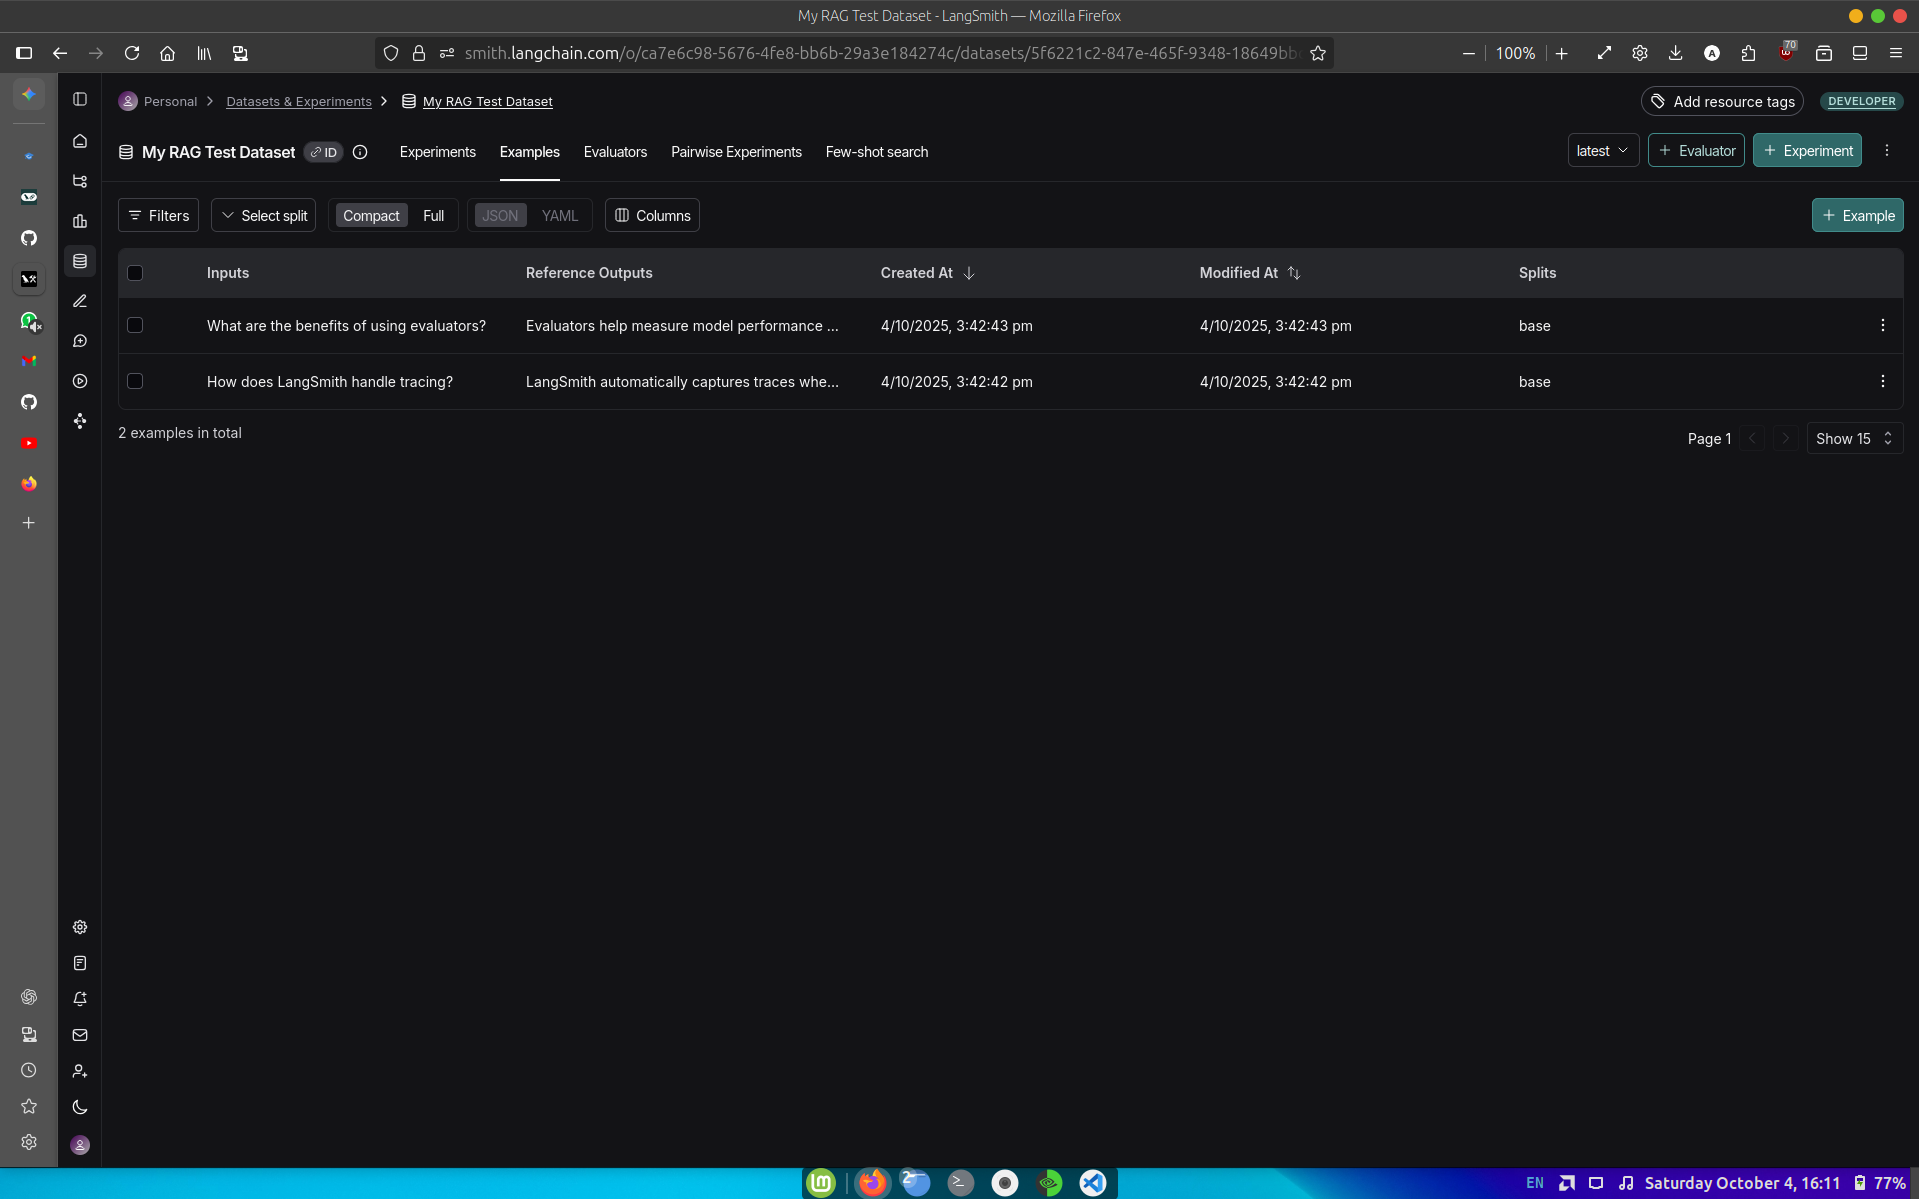